# Q2: Lets go deeper! CaffeNet for PASCAL classification (20 pts)

**Note:** You are encouraged to reuse code from the previous task. Finish Q1 if you haven't already!


As you might have seen, the performance of the SimpleCNN model was pretty low for PASCAL. This is expected as PASCAL is much more complex than FASHION MNIST, and we need a much beefier model to handle it.

In this task we will be constructing a variant of the [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) architecture, known as CaffeNet. If you are familiar with Caffe, a prototxt of the network is available [here](https://github.com/BVLC/caffe/blob/master/models/bvlc_reference_caffenet/train_val.prototxt). A visualization of the network is available [here](http://ethereon.github.io/netscope/#/preset/caffenet).


## 2.1 Build CaffeNet (5 pts)
Here is the exact model we want to build. In this task, `torchvision.models.xxx()` is NOT allowed. Define your own CaffeNet! We use the following operator notation for the architecture:
1. Convolution: A convolution with kernel size $k$, stride $s$, output channels $n$, padding $p$ is represented as $conv(k, s, n, p)$.
2. Max Pooling: A max pool operation with kernel size $k$, stride $s$ as $maxpool(k, s)$.
3. Fully connected: For $n$ output units, $FC(n)$.
4. ReLU: For rectified linear non-linearity $relu()$

```
ARCHITECTURE:
-> image
-> conv(11, 4, 96, ’VALID’)
-> relu()
-> max_pool(3, 2)
-> conv(5, 1, 256, 'SAME')
-> relu()
-> max_pool(3, 2)
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 256, ’SAME’)
-> relu()
-> max_pool(3, 2)
-> flatten()
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(20)
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import trainer
from utils import ARGS
from simple_cnn import SimpleCNN, get_fc
from voc_dataset import VOCDataset


class CaffeNet(nn.Module):
    def __init__(self, num_classes=20, inp_size=224, c_dim=3):
        super().__init__()
        self.num_classes = num_classes
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        self.conv1 = nn.Conv2d(3, 96, 11, stride=4, padding=0)
        self.conv2 = nn.Conv2d(96, 256, 5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(256, 384, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, 3, stride=1, padding=1)
        
        self.nonlinear = nn.ReLU()
        
        self.pool = nn.MaxPool2d(3, 2)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.flat_dim = (int)(256*(5)*(5))
        
        self.fc1 = nn.Sequential(*get_fc(self.flat_dim, 4096, 'relu'))
        self.fc2 = nn.Sequential(*get_fc(4096,  4096, 'relu'))
        self.fc3 = nn.Sequential(*get_fc(4096, 20, 'none'))
        
    def forward(self, x):
        N = x.size(0)
        x = self.conv1(x)
        x = self.nonlinear(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.nonlinear(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.nonlinear(x)
        
        x = self.conv4(x)
        x = self.nonlinear(x)
        
        x = self.conv5(x)
        x = self.nonlinear(x)
        x = self.pool(x)
        
        flat_x = x.view(N, self.flat_dim)
        out = self.fc1(flat_x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        
        return out
                

## 2.2 Save the Model (5 pts)
Fill out `save_model()` in `trainer.py` to save the checkpoints of the model periodically. **You will need these models later.**


## 2.3 Train and Test (5pts)
Show clear screenshots of testing MAP and training loss for 50 epochs. The final MAP should be at least around 0.4. Please evaluate your model to calculate the MAP on the testing dataset every 250 iterations. Use the following hyperparamters:
* batch_size=32
* Adam optimizer with lr=0.0001

**NOTE: SAVE AT LEAST 5 EVENLY SPACED CHECKPOINTS DURING TRAINING (1 at end)**

In [2]:
args = ARGS(test_batch_size=20, epochs=50, batch_size=32, lr=0.0001, gamma=0.7, step_size=1.2, log_every = 250, val_every = 250, use_cuda = True)
model = CaffeNet()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
test_ap, test_map = trainer.train(args, model, optimizer, scheduler, model_name='CaffeNet')
print('test map:', test_map)

Train Epoch: 0 [0 (0%)]	Loss: 0.694305
Validation MAP =  0.06880589470252227
Train Epoch: 1 [250 (59%)]	Loss: 0.236058
Validation MAP =  0.07608564714572973
Train Epoch: 3 [500 (18%)]	Loss: 0.206358
Validation MAP =  0.1198618847706733
Train Epoch: 4 [750 (78%)]	Loss: 0.214678
Validation MAP =  0.12628039872313854
Train Epoch: 6 [1000 (37%)]	Loss: 0.205067
Validation MAP =  0.15077416918167622
Train Epoch: 7 [1250 (96%)]	Loss: 0.213450
Validation MAP =  0.16421445160792278
Train Epoch: 9 [1500 (55%)]	Loss: 0.179917
Validation MAP =  0.18108070626706618
Train Epoch: 11 [1750 (15%)]	Loss: 0.206896
Validation MAP =  0.20857740396979985
Train Epoch: 12 [2000 (74%)]	Loss: 0.216856
Validation MAP =  0.21148454969154695
Train Epoch: 14 [2250 (33%)]	Loss: 0.180675
Validation MAP =  0.22216908627234383
Train Epoch: 15 [2500 (92%)]	Loss: 0.157690
Validation MAP =  0.2482756842710268
Train Epoch: 17 [2750 (52%)]	Loss: 0.191163
Validation MAP =  0.26541659645404253
Train Epoch: 19 [3000 (11%)]	Los

**INSERT YOUR TENSORBOARD SCREENSHOTS HERE**

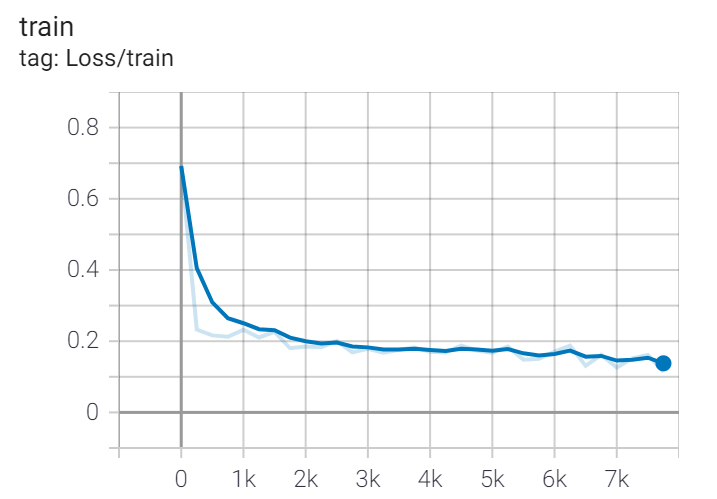

In [3]:
from IPython.display import Image
Image("./images/q2_train.png")

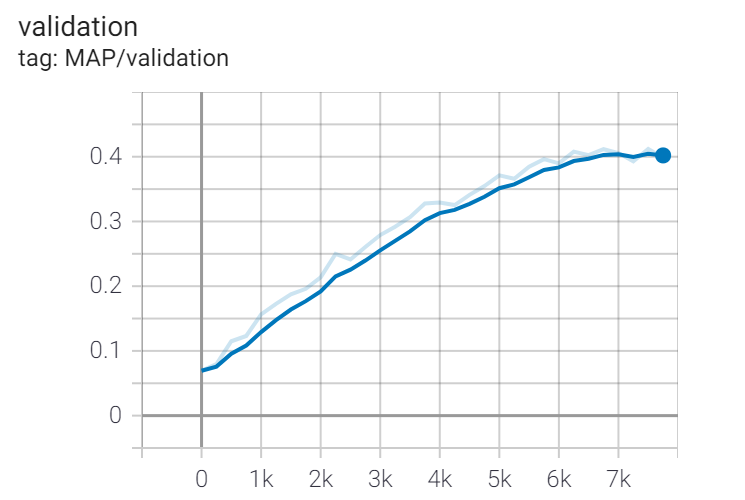

In [4]:
Image("./images/q2_validation.png")

## 2.4 Visualizing: Conv-1 filters (5pts)
Extract and compare the weights of conv1 filters at different stages of the training (at least from 5 different epochs).

- Write a function to load your model checkpoints.
- Get the weights for conv1 from the loaded model.
- Visualize the weights using the following vis() function.

Sometimes the filters all look very random and may not change too much across epochs. Don't worry! You will get full credits as long as the code is correct.

In [5]:
import numpy as np
from PIL import Image

# This function plots all the filters in one image. 
def vis(conv1):
    assert type(conv1) == np.ndarray
    assert conv1.shape == (11, 11, 3, 96)
    im = np.zeros((120, 120, 3))
    step_size = 12
    column = 0
    row = 0
    for k in range(conv1.shape[3]):
        this_filter = conv1[:, :, :, k]
        im[column*step_size:column*step_size+11, row*step_size:row*step_size+11, :] = this_filter
        column = column + 1
        if column == 10:
            column = 0
            row = row + 1
    image = Image.fromarray(np.uint8((im-np.mean(im))/np.std(im)))
    # image.show()
    return image

def model_checkpoints(model, model_name, epoch):
    filename = 'checkpoint-{}-epoch{}.pth'.format(
        model_name, epoch)
    model.load_state_dict(torch.load(filename))
    model.eval()
    
    return model

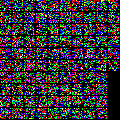

In [6]:
# Write your code here to get the conv1 filters for each epoch
# conv1s = [np.random.randn(11, 11, 3, 96)]

# For each epoch, use vis() to visualize the filters.
# Before passing the weights into vis(), make sure it is an numpy array with shape (11, 11, 3, 96).
# You may need torch.permute to reorganize the dimensions.
# vis(conv1)

model_name = 'CaffeNet'
#Epoch 10

model = CaffeNet()
epoch = 10
model = model_checkpoints(model, model_name, epoch)
conv1 = model.conv1.weight.data.numpy()
conv1 = conv1.T
vis(conv1)

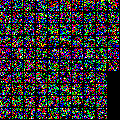

In [7]:
model_name = 'CaffeNet'
#Epoch 20

model = CaffeNet()
epoch = 20
model = model_checkpoints(model, model_name, epoch)
conv1 = model.conv1.weight.data.numpy()
conv1 = conv1.T
vis(conv1)

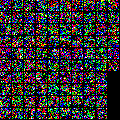

In [8]:
model_name = 'CaffeNet'
#Epoch 30

model = CaffeNet()
epoch = 30
model = model_checkpoints(model, model_name, epoch)
conv1 = model.conv1.weight.data.numpy()
conv1 = conv1.T
vis(conv1)

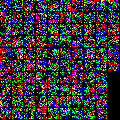

In [9]:
model_name = 'CaffeNet'
#Epoch 40

model = CaffeNet()
epoch = 40
model = model_checkpoints(model, model_name, epoch)
conv1 = model.conv1.weight.data.numpy()
conv1 = conv1.T
vis(conv1)

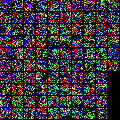

In [10]:
model_name = 'CaffeNet'
#Epoch 50

model = CaffeNet()
epoch = 50
model = model_checkpoints(model, model_name, epoch)
conv1 = model.conv1.weight.data.numpy()
conv1 = conv1.T
vis(conv1)